In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from scipy.signal import argrelextrema
import math
import numpy as np
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.legend_handler import HandlerBase
import matplotlib.pyplot as plt
import sys
import os,glob
import yaml
from scipy.special import gamma
from scipy.optimize import fsolve
from scipy.interpolate import interp1d  
import pandas as pd
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from tqdm import tqdm 

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size']=13
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='stix'
plt.rcParams['figure.figsize']= (6.5,4)
plt.rcParams['figure.dpi']=150
plt.rcParams['axes.facecolor'] = 'white'

---

In [2]:
class VDS0():  

############################# INITIALIZATION #############################
    
    def __init__(self, h = 0.6932, Omega_m = 0.23995, Omega_b = 0.04626, Omega_rad = 9.23640e-5, p_crit = 4.755e-6,
                 rho_crit = 4.755e-6, T0 = 2.7255, kb = 8.617333262145e-5, m_p = 0.93827231, nu = 1.12,
                 Y_p = 0.75, n_e = 0.18820, x_e = 1.16371, sigmaT = 6.65246e-29, c = 3e5, Mpc2cm = 3.086e24, 
                 masses = np.array([1.5e-5,1e-4,1e-3,1e-2,1e-1,1.,10.,100.]), 
                 sigma_array = np.logspace(-10,-40,600)):
        
        self.h = h
        self.H0 = 100*h
        self.Omega_m = Omega_m
        self.Omega_b = Omega_b
        self.Omega_rad = Omega_rad
        self.Y_p = Y_p
        self.m_p = m_p
        self.nu = nu
        self.n_e = n_e
        self.x_e = x_e
        self.sigmaT = sigmaT
        self.rho_crit = 1.256*10**11*Omega_m
        self.rho_b = Omega_b*p_crit
#         self.T_0 = kb*T0*1e-9
        self.T_0 = 2.353e-13        
        self.Mpc2m = Mpc2cm*1e-2
        self.Rx_conerverionFactor = c*Mpc2cm
        
        self.masses = masses
        self.sigma_array = sigma_array
            
############################# SEMI-ANALYTIC FUNCTIONS #############################
    
    def N_0(self,n):
        return pow(2,(5.+n)/2.)*gamma(3.+n/2.)/(3.*np.sqrt(np.pi))

    def mhm2khm(self,Mhm):
        return np.pi/self.h*(((4.*np.pi*self.rho_crit)/(3*Mhm))**(1./3.))
        
    def Rx(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow(((self.T_0*(1+z))/(m_x))+((self.T_0*(1+z))/self.m_p),((1.+n)/2.)))

    def Rx_noZ(self,sigma_0, m_x, n):
        return self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0/m_x)+(self.T_0/self.m_p),((1.+n)/2.)))
    
    def Rx_kin(self,z,sigma_0,m_x,n):
        return (pow(z,2) * ((self.T_0*z**2)/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*z)/self.m_p)**((n+1.)/2.))*(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p)))

    def Rx_th(self,z,sigma_0, m_x, n):
        return pow(z,2)*self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor*(sigma_0/(m_x+self.m_p))*(pow((self.T_0*z)/(m_x)+((self.T_0*z)/self.m_p),((1.+n)/2.)))
    
    def Rgamma(self,z):
        return pow(z,2)*self.n_e*self.x_e*self.sigmaT*self.Mpc2m
    
    def aH(self,z,sigma_0,m_x,n):
        return z*(self.H0*np.sqrt(self.Omega_rad))

    def z_th(self,sigma_0,m_x,n):
        return ((self.H0*np.sqrt(self.Omega_rad)*(m_x+self.m_p))/(self.Rx_noZ(sigma_0,m_x,n)*m_x))**(2./(n+3.))

    def z_kin(self,sigma_0,m_x,n):
        return fsolve(lambda z: z * pow(((self.T_0*pow(z,2))/((1+self.z_th(sigma_0,m_x,n))*m_x) + (self.T_0*z)/self.m_p),((n+1.)/2.)) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    
    
    def z_gamma(self,sigma_0,m_x,n):
        return fsolve(lambda z: pow(((self.T_0*pow(z,2))/(self.z_th(sigma_0,m_x,n)*m_x) + (self.T_0*self.z_th(sigma_0,m_x,n))/self.m_p),((n+1.)/2.)) - (self.n_e*self.x_e*self.sigmaT*self.Mpc2m/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)    

    def sigma2k(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_kin(sigma_0,m_x,n))*3.33e-6
    
    def sigma2k2(self,sigma_0,m_x,n):
        return 2*(self.H0*np.sqrt(self.Omega_rad)*self.z_gamma(sigma_0,m_x,n))*3.33e-6

    def sig(self,klimit,n,masses):
        sigma = []
        for i in range(len(masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k(self.sigma_array,masses[i],n)-self.h*klimit))])
        return np.array(sigma)

    def sig2(self,klimit,n):
        sigma = []
        for i in range(len(self.masses)):
            sigma.append(self.sigma_array[np.argmin(np.abs(self.sigma2k2(self.sigma_array,self.masses[i],n)-self.h*klimit))])
        return np.array(sigma)
    
    def sigma_vs_mx(self,klimit,n):
        return hv.Curve((masses, self.sig(klimit,n)))
    
############################# INI GENERATION #############################

    def make_inis(self,ini_base_file='class/inis/dmeff_base.ini',base_inis_path='class/inis/',class_runner_path = 'class/',npow=0,
                  masses=np.array([1e-4,1e-3,1e-2,1e-1,1.,10.]),sigmas=np.logspace(-20,-30,100),output_path='pk_output',
                  sh_file='class/run_classes.sh'):
    
        fin =  open(ini_base_file, 'r')
        base_content = fin.read()
        fin.close()
        fout_sh = open(class_runner_path+'run_classes.sh', 'w')

        for m in masses:
            for sigma in sigmas:
                filename = 'n{}_m{}_s{}.ini'.format(npow,m,sigma)
                fout_sh.write('./class ' + 'inis/{}\n'.format(filename))
                fout = open(base_inis_path + filename, 'w')
                fout.write(base_content)
                fout.write('\n')
                npow_line = 'npow_dmeff = {}\n'.format(npow)
                fout.write(npow_line)
                m_line = 'm_dmeff = {}\n'.format(m)
                fout.write(m_line)
                sigma_line = 'sigma_dmeff = {}\n'.format(sigma)
                fout.write(sigma_line)
                if npow<0:
                    vel_line = 'Vrel_dmeff_rate = 30\n' #sets to DBK case.
                    fout.write(vel_line)
                root_line = 'root = {}/n{}_m{}_s{}_\n'.format(output_path,npow,m,sigma)
                fout.write(root_line)

        fout_sh.close()

############################# TK PLOTTING FUNCTIONS #############################
        
    def single_tk(self,npow=0,m=0.0001,plotPeaks=False,pltType='none',
                  index=0,sigmas=np.logspace(-20,-30,100),lw=2.5,label='',
                  c='k',ls='-',alpha=1):

        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            # Index of interest
            if i!=index:
                continue
            print(sigma)
            
            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)   
            print(filename)
            data = np.loadtxt(filename)
            pk = data[:,1]
            ax.plot(ks,pk[:255]/pk0[:255],linewidth=lw,linestyle=ls,color=c,label=label,alpha=alpha)

        return (pk[:255])/pk0[:255],ks,sigma
    
    def all_sigmas(self,npow=0,m=0.0001,sigmas=np.logspace(-20,-30,100),
               z='z1',colorbar=False,pk_root='class/pk_output/',
               filename=None,label='',lw=0.3,lowlim=0,uplim=100,c='r'):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#D81B60','tan','#63acbe'])
        cm2 = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
        
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,sigma in enumerate(sigmas):
            if i>=uplim or i<lowlim or i==len(sigmas)-1 or i%5!=0:
                continue
                
            # colors/labels for peak plot
            lbl = "$\sigma_0=$"+str('{:.1e}'.format(float(sigma)))+r"$\textrm{ cm}^2$"
            c=cm(int(i*4.))

            try:                                    
                # pk data from class for given mass, sigma, power
                filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
                data = np.loadtxt(filename)
                pk = data[:,1]
                ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,alpha=1.) 
                sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm2,s=0.001,alpha=0.7)
            except: continue

#         if colorbar:
#             tick_locs = [1e-30,1e-20]
#             tick_labels = ["$\sigma_0 = 10^{-30}$ cm$^2$","$\sigma_0 = 10^{-20}$ cm$^2$"]
#             cb = plt.colorbar(sc, orientation="vertical")
#             cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
#             cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
#             cb.update_ticks()
#             cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
#             cb.ax.locator_params(nbins=2)
           
    def all_masses(self,npow=0,masses=[1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1],
                   sigma=1e-20,z='z1',colorbar=False,pk_root='class/pk_output/',
                   filename=None,label='',lw=0.3):
        
        cm = LinearSegmentedColormap.from_list("mycmap", ['#63acbe','tan','#D81B60'])
    
        data0 = np.loadtxt('class/pk_output/lcdm_z1_pk.dat')
        ks = data0[:,0]
        pk0 = data0[:,1]

        for i,m in enumerate(masses):
            lbl = "$\mass=$"+str('{:.1e}'.format(float(m)))+r"$\textrm{ GeV}$"
            c=cm(int(i*35.))

            # pk data from class for given mass, sigma, power
            filename = 'class/pk_output/n{}_m{}_s{}_z1_pk.dat'.format(npow,m,sigma)            
            data = np.loadtxt(filename)
            pk = data[:,1]

            ax.semilogx(ks,pk/pk0,linewidth=lw,linestyle='-',color=c,label=lbl,alpha=1.) 
            sc = plt.scatter(ks,(pk)/pk0, c=np.logspace(-20,-30,246), cmap=cm,s=0.001,alpha=0.7)
                
        if colorbar:
            tick_locs = [1e-30,1e-20]
            tick_labels = ["$m = 10^{-5}$ GeV","$m = 10$ GeV"]
            cb = plt.colorbar(sc, orientation="vertical")
            cb.locator = matplotlib.ticker.FixedLocator(tick_locs)
            cb.formatter = matplotlib.ticker.FixedFormatter(tick_labels)
            cb.update_ticks()
            cb.ax.tick_params(labelsize=33,length=15,width=3,color='w')
            cb.ax.locator_params(nbins=2)
            
    def transfer(self,k,mwdm):
        lambda_fs = (0.049*(mwdm**(-1.11))*((self.Omega_m/0.25)**(0.11))*((self.h/0.7)**1.22))
        alpha = lambda_fs
        transfer = (1+(alpha*k)**(2*self.nu))**(-5./self.nu)
        return transfer

In [3]:
vds0 = VDS0()

---

**Instructions for Figure 3:**<br>
Below are the limits used in Figure 3. The conservative limits are hardcoded as per the above. The analytic limits call the sig() function which calculates the limits for the given klim (from Mmin)

In [4]:
klim = vds0.mhm2khm(3.2*10**8)
mass = vds0.masses
mass6 = np.logspace(-5,2,25)
mass4 = [1.5e-5,1e-4,3e-4,1e-3,1e-2,1e-1,1.,10.,100.]
mass_eft6 = [1,1000]
mass_eft = [1.5e-5,0.001,1,1000]

sigs0cons = np.array([2.682695795279738e-29,   #1.5e-5
                      6.866488450043026e-29,   #1e-4
                      1.7575106248547966e-28,  #1e-3
                      2.8117686979742367e-28,  #1e-2
                      4.498432668969453e-28,   #1e-1
                      1.8420699693267164e-27,  #1
                      1.2067926406393265e-26,  #10
                      1.2648552168552905e-25]) #100

sigs2cons = np.array([6.866488450043026e-29,
                      7.543120063354607e-27,
                      8.28642772854686e-25,
                      1.389495494373136e-23,
                      1.4563484775012383e-22,
                      1.5264179671752366e-21,
                      1.2648552168552906e-20,
                      1.3257113655901108e-19])

sigs4cons = np.array([1.5264179671752366e-29,
                      1.9306977288832457e-26,
#                       1.389495494373136e-23,
                      1.7575106248547966e-21,
                      2.1209508879201925e-19,
                      2.94705170255181e-17,
                      5.455594781168515e-16,
                      1.389495494373136e-14,
                      1.389495494373136e-13])

sigs6cons = np.array([1.9306977288832455e-30,
                      6.951927961775591e-24,
                      6.309573444801943e-16,
                      1e-12,
                      4.832930238571752e-11,
                      6.15848211066028e-10,
                      7.847599703514623e-09,
                      1e-07])

sigs0_anal = [vds0.sig(klim,0.,mass)[0],vds0.sig(klim,0.,mass)[1],vds0.sig(klim,0.,mass)[2],vds0.sig(klim,0.,mass)[3],vds0.sig(klim,0.,mass)[4],vds0.sig(klim,0.,mass)[5],vds0.sig(klim,0.,mass)[6],vds0.sig(klim,0.,mass)[7]]
sigs2_anal = [vds0.sig(klim,2.,mass)[0],vds0.sig(klim,2.,mass)[1],vds0.sig(klim,2.,mass)[2],vds0.sig(klim,2.,mass)[3],vds0.sig(klim,2.,mass)[4],vds0.sig(klim,2.,mass)[5],vds0.sig(klim,2.,mass)[6],vds0.sig(klim,2.,mass)[7]]
sigs4_anal = [vds0.sig(klim,4.,mass)[0],vds0.sig(klim,4.,mass)[1],vds0.sig(klim,4.,mass)[2],vds0.sig(klim,4.,mass)[3],vds0.sig(klim,4.,mass)[4],vds0.sig(klim,4.,mass)[5],vds0.sig(klim,4.,mass)[6],vds0.sig(klim,4.,mass)[7]]
# sigs6_anal = [vds0.sig(klim,6.,mass)[0],vds0.sig(klim,6.,mass)[1],vds0.sig(klim,6.,mass)[2],vds0.sig(klim,4.,mass)[3],vds0.sig(klim,6.,mass)[4],vds0.sig(klim,6.,mass)[5],vds0.sig(klim,6.,mass)[6],vds0.sig(klim,6.,mass)[7]]
sigs6_anal = [vds0.sig(klim,6.,mass6)[i] for i in tqdm(range(len(mass6)))]

sigs0_eft = np.array([8.8e-27,2.6e-26,1.5e-25,1.4e-23])
sigs2_eft = np.array([4.2e-23,4.3e-21,5.3e-18,2.2e-15])
sigs4_eft = np.array([1.6e-20,1.0e-16,4.1e-11,9.3e-09])
sigs6_eft = np.array([5.0e-04,1.5e+00])


  0%|          | 0/25 [00:00<?, ?it/s]<ipython-input-2-09e561baed93>:62: RuntimeWarning: invalid value encountered in power
  return fsolve(lambda z: z * pow(((self.T_0*pow(z,2))/((1+self.z_th(sigma_0,m_x,n))*m_x) + (self.T_0*z)/self.m_p),((n+1.)/2.)) - (self.H0*np.sqrt(self.Omega_rad)/(self.N_0(n)*self.Y_p*self.rho_b*self.Rx_conerverionFactor))*(m_x+self.m_p)/sigma_0,self.z_th(sigma_0,m_x,n)/2.)
100%|██████████| 25/25 [12:31<00:00, 30.04s/it]


In [5]:
firas = np.loadtxt('data/FIRAS_lims.dat')
mass_firas = firas[:,0]
firasN0 = firas[:,1]
firasN2 = firas[:,2]
firasN4 = firas[:,3]
firasN6 = firas[:,4]

#limits from Xu et al, for Lya+Planck(TTEE), Table 1 https://arxiv.org/pdf/1802.06788.pdf
sigs0_xu = np.array([5.8e-26,1.2e-26,5.6e-27])
sigs2_xu = np.array([2.4e-20,4.9e-21,2.3e-21])
mass_xu = np.array([1e1,1.,1e-2])

To get individual n plot, just change n below in the first line and run the cell.

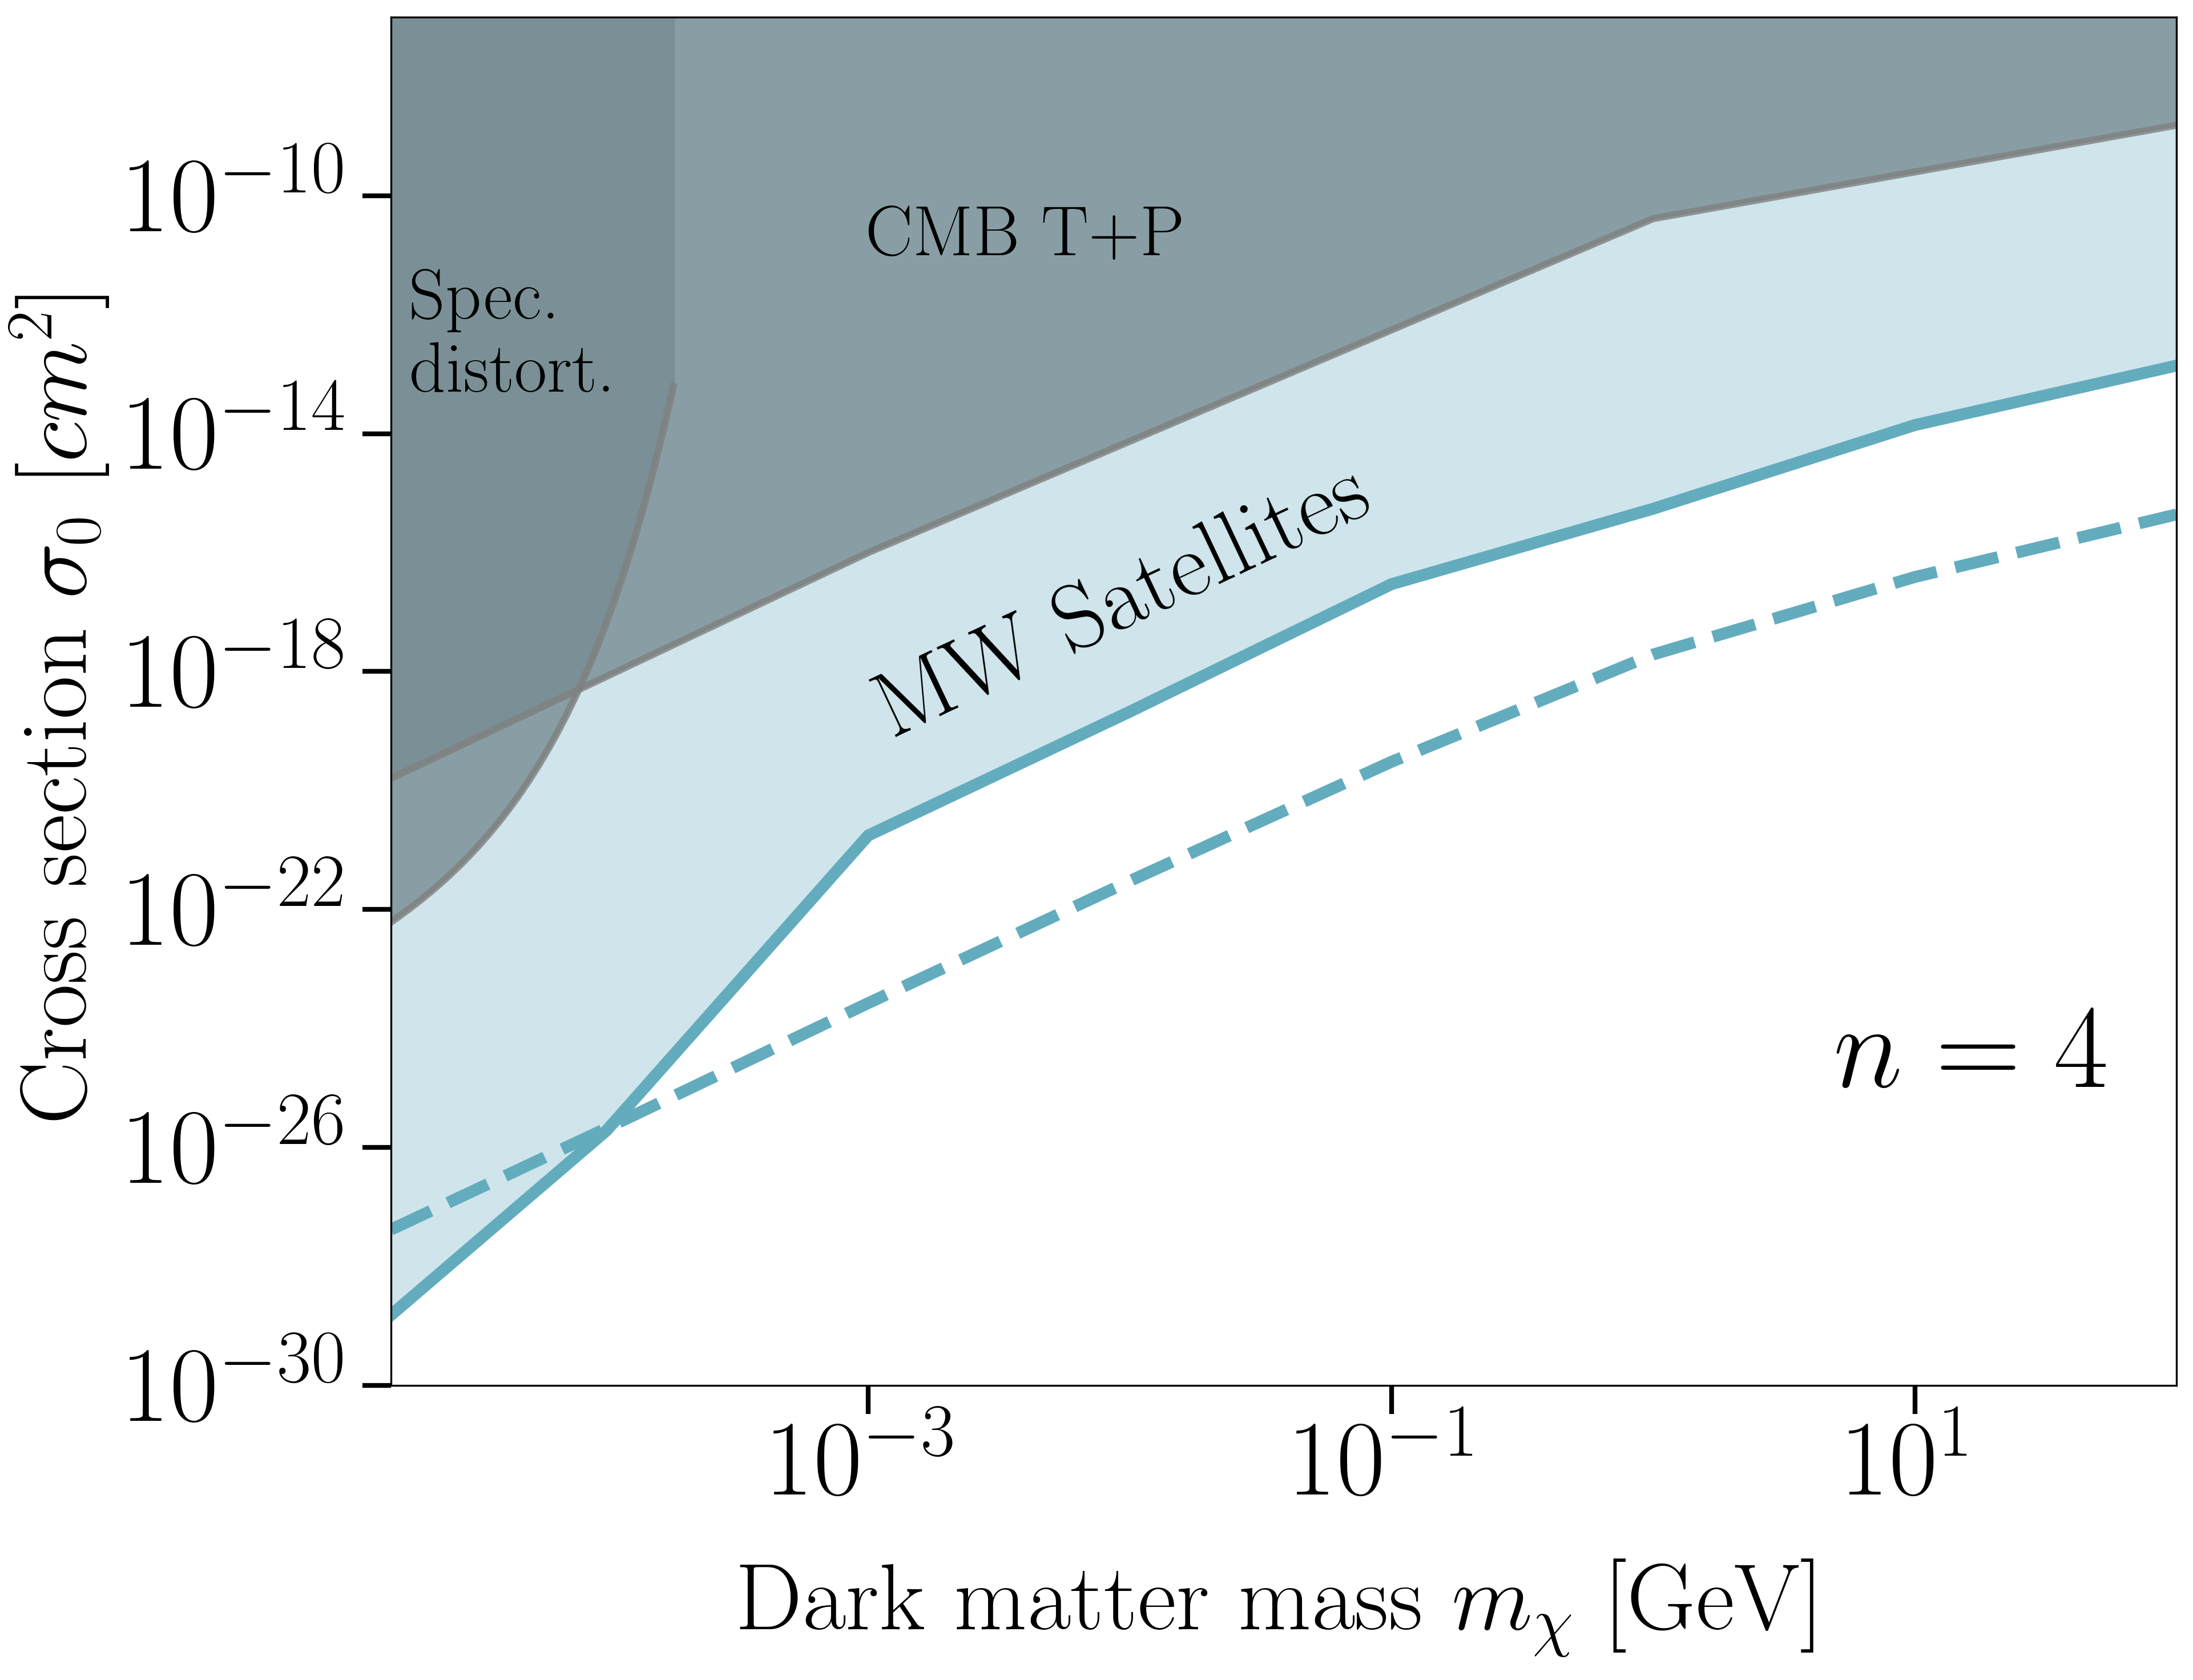

In [6]:
n = 4

if (n==0 or n==2 or n==4):
    exec(f'sigs_eft = sigs{n}_eft')
if (n==0 or n==2):
    exec(f'sigs_xu = sigs{n}_xu')
exec(f'sigs_firas = firasN{n}')
exec(f'sigs_anal = sigs{n}_anal')
exec(f'sigs_cons = sigs{n}cons')

plt.figure(figsize=(13,10))
alpha_previous = 0.8
lw_previous = 3
alpha_thiswork = 0.3
lw_thiswork = 5
color_previous = 'grey'

myred = '#D81B60'
myblue = '#63acbe'
mybluedark = '#39636e'

if (n==0 or n==2 or n==4):
    plt.loglog(mass_eft,sigs_eft,c=color_previous,lw=lw_previous,alpha=alpha_previous)
    plt.fill_between(mass_eft, sigs_eft, 1, color=color_previous, alpha=alpha_previous)
if (n==0 or n==2):
    plt.loglog(mass_xu,sigs_xu,c=color_previous,lw=lw_previous,alpha=alpha_previous)
    plt.fill_between(mass_xu, sigs_xu, 1, color=color_previous, alpha=alpha_previous)

plt.loglog(mass_firas,sigs_firas,c=color_previous,lw=lw_previous,alpha=alpha_previous)   
plt.fill_between(mass_firas, sigs_firas, 1, color=color_previous, alpha=alpha_previous)

plt.fill_between(mass, sigs_cons, 1, color=myblue, alpha=alpha_thiswork)
if n==6:
    mass_a = mass6
else:
    mass_a = mass
plt.loglog(mass_a, sigs_anal,label="Analytic estimate",lw=lw_thiswork,linestyle='--',c=myblue)
plt.loglog(mass,sigs_cons,label="Numerical limit",linestyle='-',c=myblue,lw=lw_thiswork)

plt.xlim(1.5e-5,1e2)
plt.ylabel(r"Cross section $\sigma_0$ [$cm^2$]",fontsize=40,labelpad=5)
plt.xlabel(r"Dark matter mass $m_\chi$ [GeV]",fontsize=40,labelpad=20)
# plt.legend(fontsize=30,loc='lower right',framealpha=1.)
if n==0:
    plt.legend(fontsize=30,loc='upper right',framealpha=1.)
plt.tick_params(labelsize=45,length=12,width=2)
plt.tick_params(which='minor',length=8,width=1.5)

if n==0:
    plt.text(5,1e-28,"$n=0$",fontsize=50)
    plt.ylim(1e-30,1e-17)
    plt.text(1.8e-5,1e-23,"Spec.\n distort.",fontsize=30, rotation=0)
    plt.text(3e-2,2e-24,r"Lyman-$\alpha$ forest",fontsize=30, rotation=0)
    plt.text(3e-4,1e-21,"CMB T+P",fontsize=30, rotation=0)
    plt.text(4e-5,3.5e-28,"MW Satellites",fontsize=40, rotation=7,color='k')


if n==2:
    plt.text(5,1e-27,"$n=2$",fontsize=50)
    plt.ylim(1e-30,1e-17)
    plt.text(1.8e-5,1e-20,"Spec.\n distort.",fontsize=30, rotation=0)
    plt.text(3e-2,2e-20,r"Lyman-$\alpha$ forest",fontsize=30, rotation=0)
    plt.text(2e-4,1e-19,"CMB T+P",fontsize=30, rotation=0)
    plt.text(4e-5,1e-24,"MW Satellites",fontsize=40, rotation=25,color='k')

if n==4:
    plt.text(5,1e-25,"$n=4$",fontsize=50)
    plt.ylim(1e-30,1e-7) 
    plt.text(1.8e-5,5e-14,"Spec.\n distort.",fontsize=30, rotation=0)
    plt.text(1e-3,1e-11,"CMB T+P",fontsize=30, rotation=0)
    plt.text(1e-3,8e-20,"MW Satellites",fontsize=39.5, rotation=25.3,color='k')

if n==6:
    plt.text(5,8e-26,"$n=6$",fontsize=50)
    plt.ylim(1e-30,1e-7) 
    plt.text(1.8e-5,1e-13,"Spec.\n distort.",fontsize=30, rotation=0)
    plt.text(5e-4,5e-14,"MW Satellites",fontsize=40, rotation=30,color='k')


plt.tight_layout()
exec(f'plt.savefig("plots/limits/limits_n{n}.png")')
